# Practical Time Series Analysis & Forecast (Individual Household Electric Power Consumption)
**Data Set Information:**

This [*archive*](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption) contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).




---


**Attribute Information:**


*   date: Date in format dd/mm/yyyy

*   time: time in format hh:mm:ss

*   globalactivepower: household global minute-averaged active power (in kilowatt)
*   globalreactivepower: household global minute-averaged reactive power (in kilowatt)


*   voltage: minute-averaged voltage (in volt)


*   global_intensity: household global minute-averaged current intensity (in ampere)


*   submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

*   submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

*   submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.






In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import rcParams
from prophet.plot import plot_components
import warnings
warnings.filterwarnings("ignore")
import zipfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#upzipping the downloaded zip file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/household_power_consumption.zip", 'r')
#location to unzip
zip_ref.extractall("/content/drive/MyDrive/")
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#reading the data
df= pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt",sep=";", parse_dates = [["Date","Time"]])

In [4]:
df.head(3)

,Date_Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date_Time              datetime64[ns]
 1   Global_active_power    object        
 2   Global_reactive_power  object        
 3   Voltage                object        
 4   Global_intensity       object        
 5   Sub_metering_1         object        
 6   Sub_metering_2         object        
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 126.7+ MB


### Data Preprocessing

In [6]:
df[["Global_active_power","Global_reactive_power","Voltage","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"]]=df[["Global_active_power","Global_reactive_power","Voltage","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"]].apply(pd.to_numeric,errors='coerce')
df.isnull().sum()

Date_Time                    0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
df.ffill(inplace=True)
df.isnull().sum()

Date_Time                0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date_Time              datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [9]:
df.head(3)

,Date_Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0


### Firstly, forward-fill all the missing values.Resample the data from a minute sampling rate to an hourly sampling rate (i.e sum over the minutes for each hour).





In [10]:
#Resampling to hourly
df_1=df.resample("H",on="Date_Time").sum()
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: H
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34589 non-null  float64
 1   Global_reactive_power  34589 non-null  float64
 2   Voltage                34589 non-null  float64
 3   Global_intensity       34589 non-null  float64
 4   Sub_metering_1         34589 non-null  float64
 5   Sub_metering_2         34589 non-null  float64
 6   Sub_metering_3         34589 non-null  float64
dtypes: float64(7)
memory usage: 2.1 MB


In [11]:
df_1.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0


 **Which of the following is a plot of the hourly global_active_power over time?**


Text(0, 0.5, 'Global_active_power')

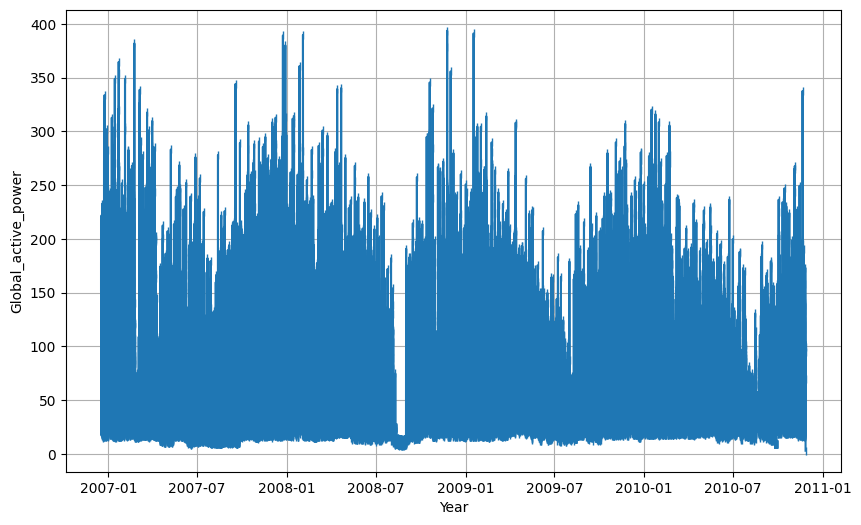

In [12]:
#plottingg Global_active_power over time
plt.figure(figsize=(10,6))
plt.plot(df_1.index, df_1.Global_active_power, '-', marker='|', )
plt.grid()
plt.xlabel("Year")
plt.ylabel('Global_active_power')

**What is the Pearson correlation coefficient between the global_active_power and voltage? To 3 decimal places**

In [13]:
df_1.corr(method='pearson').round(3)['Global_active_power']['Voltage']

-0.341

**What is the Pearson correlation coefficient between the Voltage and global_intensity? To 2 decimal places.**

In [14]:
df_1.corr(method='pearson').round(2)['Voltage']['Global_intensity']

-0.35

### Using the daily sampling rate (sum), divide the data into a train and test set. The last 300 days is your test set and the first (x-300) days is your training set. Where x is the length of the dataset. Use Facebook Prophet to train a Univariate time series modeling using this time column (‘dt’ or ‘ds’) and the global_active_power (or ‘y’).

In [15]:
#Resampling to Day
day_resample= df.resample("D",on="Date_Time").sum()
day_resample.reset_index(inplace=True)
df_2 = day_resample.copy()
df_2.head(3)

,Date_Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0


In [16]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date_Time              1442 non-null   datetime64[ns]
 1   Global_active_power    1442 non-null   float64       
 2   Global_reactive_power  1442 non-null   float64       
 3   Voltage                1442 non-null   float64       
 4   Global_intensity       1442 non-null   float64       
 5   Sub_metering_1         1442 non-null   float64       
 6   Sub_metering_2         1442 non-null   float64       
 7   Sub_metering_3         1442 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 90.2 KB


In [17]:
#renaming columns
new = df_2[['Date_Time', 'Global_active_power']]
new.rename(columns={"Date_Time": "ds", "Global_active_power": "y"},inplace=True)
new.head()

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [18]:
#spliting test and train dataset
x=len(new)-300
train=new[:x]
test=new[x:]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 1142 to 1441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      300 non-null    datetime64[ns]
 1   y       300 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.8 KB


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1142 non-null   datetime64[ns]
 1   y       1142 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 18.0 KB


In [20]:
#Importing Prophet and fitting model
from prophet import Prophet
model = Prophet()
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyq2jyov5/qn4dx1wy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyq2jyov5/ysbyaxwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23434', 'data', 'file=/tmp/tmpyq2jyov5/qn4dx1wy.json', 'init=/tmp/tmpyq2jyov5/ysbyaxwy.json', 'output', 'file=/tmp/tmpyq2jyov5/prophet_model_h8q1mgg/prophet_model-20240617235529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:55:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:55:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [21]:
#Prediciting test dataset
forecast = model.predict(test)
#Creating a dataset with y,ds and yhat
forecast_merged = pd.merge(test[["ds", "y"]], forecast[['ds','yhat']], on="ds")
forecast_merged.head()

,ds,y,yhat
0,2010-01-31,1799.196,2432.237708
1,2010-02-01,1693.778,2056.789680
2,2010-02-02,2157.432,2193.262581
3,2010-02-03,2903.014,2187.598834
4,2010-02-04,2316.270,2006.677420


**What is the MAPE and RMSE (in %) in 2 decimal places?**

In [22]:
#Metrics calculation for MAPE and RMSE
Y = np.array(forecast_merged["y"])
Y_pred = np.array(forecast_merged["yhat"])

# Mean Absolute Percentage Error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
mape = mean_absolute_percentage_error(Y,Y_pred)*100
print('MAPE is ' '%.2f'%mape)

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(Y,Y_pred))
print('RMSE is ''%.2f'%rmse )


MAPE is 27.20
RMSE is 401.61


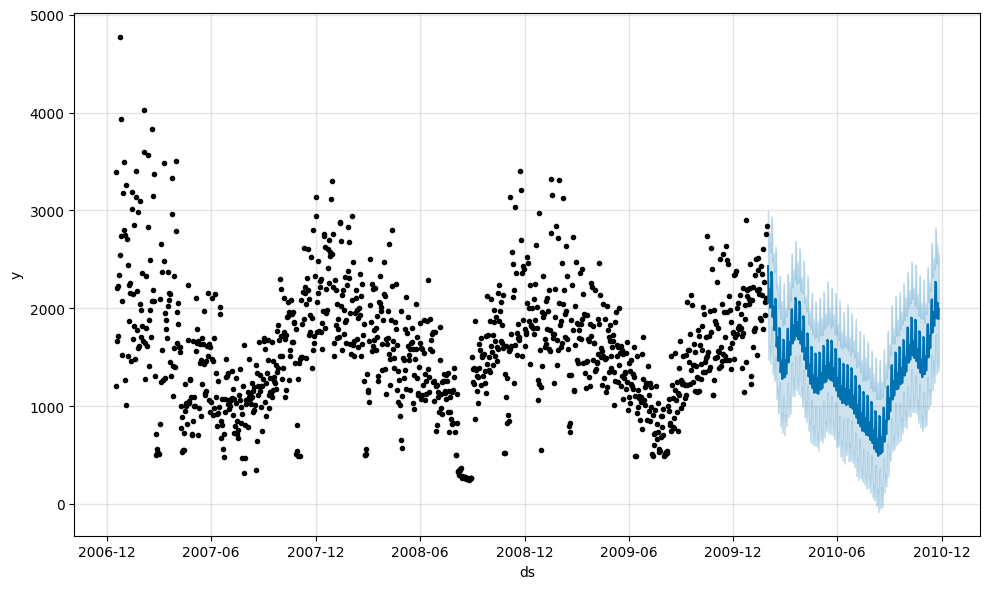

In [23]:
#plot of the predicted values
model.plot(forecast);

**If you plot the components from the forecasted model, what day of the weekly seasonality has the lowest value?**

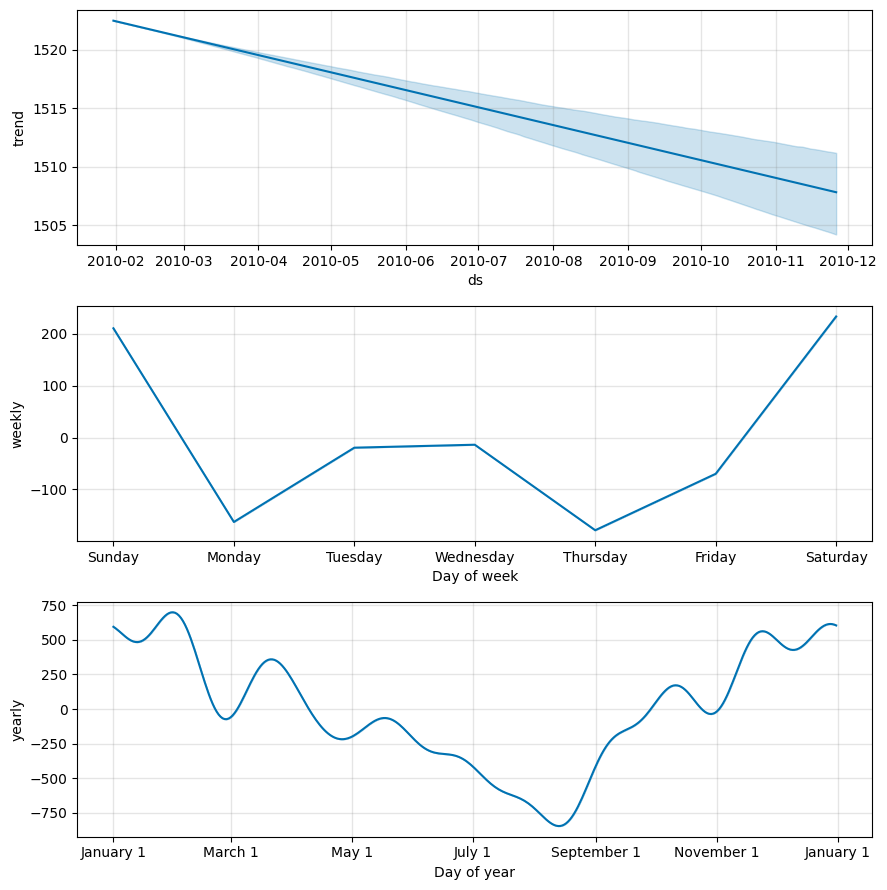

In [24]:
#plotting the components of the predicted values
model.plot_components(forecast);

### Multivariate Time Series Forecasting with Facebook Prophet

**In the last exercise, we used only the dependent variable (Global_Active_Power) and the time component for our modeling (ds vs y). Next, we will build a time series model using the other variables. These variables will be added to the forecast model as a regressor on Facebook Prophet. So the six independent variables ['Global_reactive_power', 'Voltage','Global_intensity', 'Sub_metering_1','Sub_metering_2','Sub_metering_3'] will be [‘add1’, ‘add2’, ‘add3’, ‘add4’, ‘add5’, ‘add6’] as the regressors. Split the data into train and test as done above and build a multivariate forecast model to forecast the last 300 days of the house consumption (‘global_active_power’)**

In [25]:
#renaming features
df_3 = day_resample.copy()
multi=df_3.rename(columns={'Date_Time':'ds','Global_active_power':'y','Global_reactive_power':'add1',
'Voltage':'add2','Global_intensity':'add3','Sub_metering_1':'add4','Sub_metering_2':'add5','Sub_metering_3':'add6'})
multi.head(5)

,ds,y,add1,add2,add3,add4,add5,add6
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [26]:
#adding regressors
model_2 = Prophet()
model_2.add_regressor('add1')
model_2.add_regressor('add2')
model_2.add_regressor('add3')
model_2.add_regressor('add4')
model_2.add_regressor('add5')
model_2.add_regressor('add6')

In [27]:
multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1442 non-null   datetime64[ns]
 1   y       1442 non-null   float64       
 2   add1    1442 non-null   float64       
 3   add2    1442 non-null   float64       
 4   add3    1442 non-null   float64       
 5   add4    1442 non-null   float64       
 6   add5    1442 non-null   float64       
 7   add6    1442 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 90.2 KB


In [28]:
#Splitting train and test datasets
x= len(multi)-300
multi_train=multi[:x]
multi_test=multi[x:]

In [29]:
#fitting model
model_2.fit(multi_train)
#predicting model from test dataset
forecast_2 = model_2.predict(multi_test)
#creating a dataframe with ds,y and yhat from the multivariate model
forecast_merged_2 = pd.merge(multi_test[["ds", "y"]], forecast_2[['ds','yhat']], on="ds")
forecast_merged_2.head(2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyq2jyov5/n82e8rwp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyq2jyov5/n9yy77cp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73126', 'data', 'file=/tmp/tmpyq2jyov5/n82e8rwp.json', 'init=/tmp/tmpyq2jyov5/n9yy77cp.json', 'output', 'file=/tmp/tmpyq2jyov5/prophet_modele_7wczbc/prophet_model-20240617235532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:55:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:55:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,y,yhat
0,2010-01-31,1799.196,1809.715092
1,2010-02-01,1693.778,1705.033307


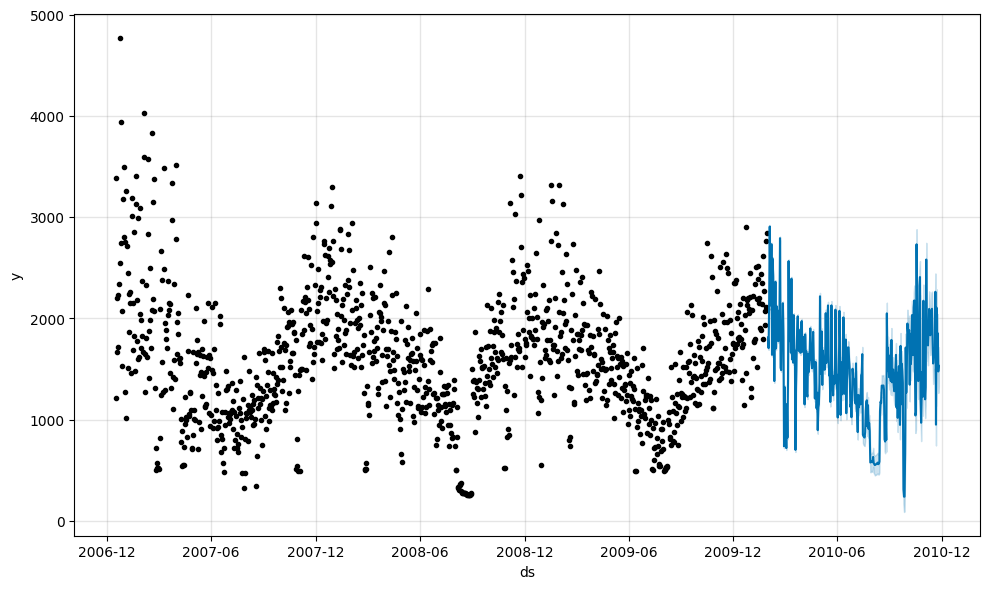

In [30]:
#plotting the predicted values
model_2.plot(forecast_2);

***What is the MAPE and RMSE (in %) in 2 decimal places?***

In [31]:
#Metrics Calculation for MAPE and RMSE
Y_2 = np.array(forecast_merged_2["y"])
Y_pred_2 = np.array(forecast_merged_2["yhat"])

# Mean Absolute Percentage Error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
mape = mean_absolute_percentage_error(Y_2,Y_pred_2)*100

print('MAPE is ' '%.2f'%mape)

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(Y_2,Y_pred_2))
print('RMSE is ''%.2f'%rmse )


MAPE is 2.49
RMSE is 33.83



*   **What day of the daily seasonality has the lowest value?**
*   **If you plot the components from the forecasted model, what month of the yearly seasonality has the lowest value**



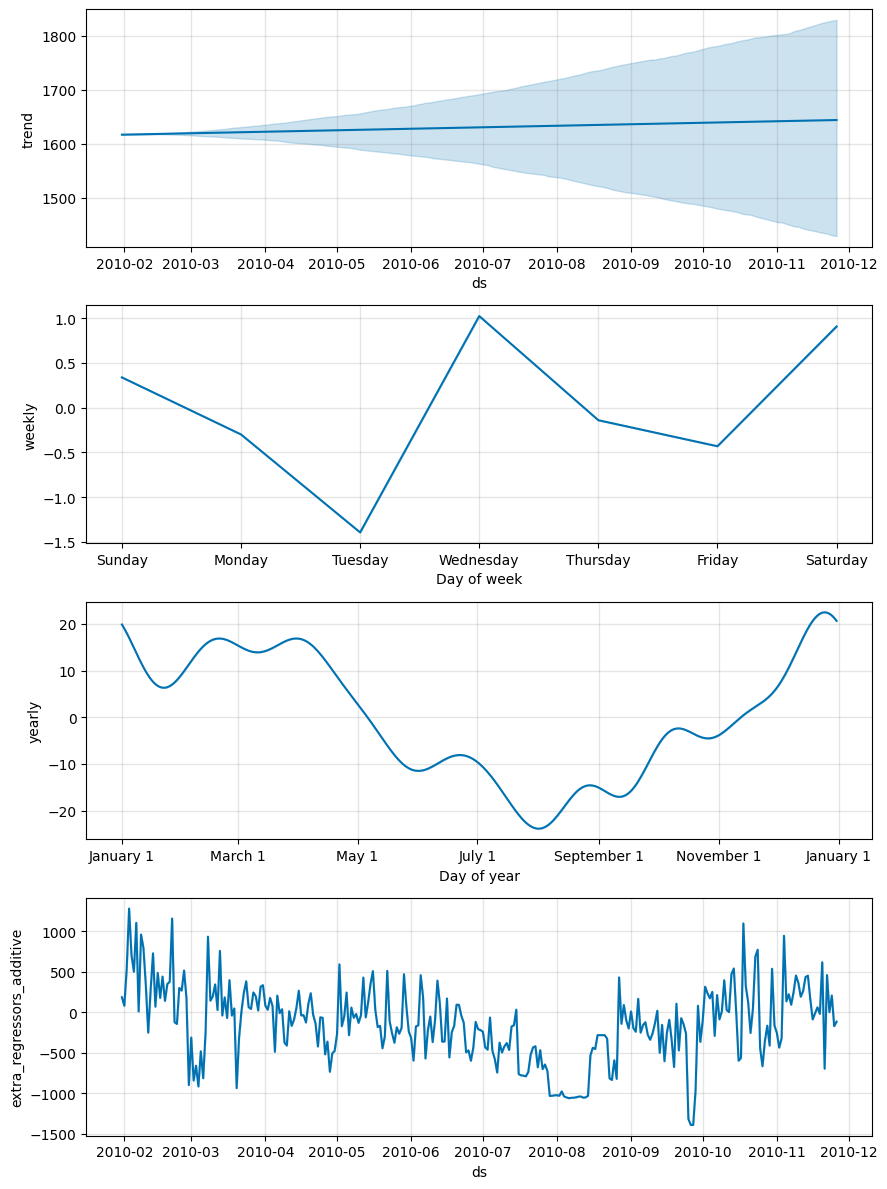

In [32]:
#plotting components of the multivariate model
model_2.plot_components(forecast_2);

# END